In [1]:
import glob
import pickle
import itertools
import numpy as np 
import pandas as pd
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer


/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_93731/3296619640.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
dataset = "real1_final"
file = f"/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_projects/data/raw_csv/{dataset}.csv"

In [57]:
# read_file and check type
orig_df = pd.read_csv(file,sep='\t')
orig_df = orig_df.dropna(subset=['FILTER_Mutect2', 'FILTER_Freebayes','FILTER_Vardict','FILTER_Varscan'])

# Ensure type if this step fails check
orig_df = orig_df.astype({"f_AC": 'float64',"f_AF": 'float64',"f_LEN": 'float64'})
display(orig_df.info())

#  45  f_AC              42745 non-null  object 
#  46  f_AF              42745 non-null  object 
#  47  f_LEN             42745 non-null  object 

<class 'pandas.core.frame.DataFrame'>
Index: 49354 entries, 0 to 49364
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        49354 non-null  int64  
 1   Chr               49354 non-null  object 
 2   START_POS_REF     49354 non-null  int64  
 3   END_POS_REF       49354 non-null  int64  
 4   REF               49354 non-null  object 
 5   ALT               49354 non-null  object 
 6   REF_MFVdVs        49354 non-null  object 
 7   ALT_MFVdVs        49354 non-null  object 
 8   Sample_Name       49354 non-null  object 
 9   FILTER_Mutect2    49354 non-null  object 
 10  FILTER_Freebayes  49354 non-null  object 
 11  FILTER_Vardict    49354 non-null  object 
 12  FILTER_Varscan    49354 non-null  object 
 13  m2_MQ             8748 non-null   float64
 14  m2_FS             8748 non-null   float64
 15  m2_MQ0            8748 non-null   float64
 16  m2_MQRankSum      8746 non-null   float64
 17

/var/folders/h7/fr7g30_x5x12d68ww_s6w2_m0000gn/T/ipykernel_93731/1350667506.py:2: DtypeWarning: Columns (1,9,10,11,12,52) have mixed types. Specify dtype option on import or set low_memory=False.
  orig_df = pd.read_csv(file,sep='\t')


None

In [24]:
# Process unclean rows
print(np.unique(orig_df['f_AC'].astype(str)))
print(np.unique(orig_df['f_AF'].astype(str)))
print(np.unique(orig_df['f_LEN'].astype(str)))

['1.0' '2.0' '3.0' '4.0' 'nan']
['0.25' '0.5' '0.75' '1.0' 'nan']
['1.0' '10.0' '11.0' '12.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0'
 '2.0' '20.0' '21.0' '22.0' '23.0' '24.0' '26.0' '27.0' '29.0' '3.0'
 '30.0' '31.0' '32.0' '33.0' '35.0' '36.0' '37.0' '4.0' '5.0' '53.0' '6.0'
 '7.0' '8.0' '9.0' 'nan']


In [42]:
features_to_remove = [
    'Unnamed: 0',
    'Chr',
    'START_POS_REF',
    'END_POS_REF',
    'f_AF',
    'f_GTI',
    'f_AC',
    'f_NUMALT',
    'f_AO',
    'f_LEN',
    'f_AN',
    'ALT',
    'REF_MFVdVs',
    'ALT_MFVdVs',
    'Sample_Name',
    'vd_SAMPLE',
    'f_MIN_DP',
    'm2_PON',
    'f_NS',
    'f_PAO',
    'f_PQR',
    'f_PRO',
    'f_PQA',
    'f_QA',
    'f_RO',
    'f_RPL',
    'is_snv']

feature_list = [x for x in list(orig_df.columns) if x not in features_to_remove]
display(len(feature_list))


30

# Missing Data Exploration

#### The entirely missing column includes  
1. m2_PON              1.000000 -- Description="Count from Panel of Normals">
2. f_MIN_DP            1.000000 -- Description="Total read depth at the locus">
3. vd_SAMPLE           0.999878 -- Description="Sample name (with whitespace translated to underscores)">

m2_PON              1.000000
f_MIN_DP            1.000000
vd_SAMPLE           0.999878
f_AB                0.847199
f_ODDS              0.847199
f_AO                0.847199
f_GTI               0.847199
f_RPP               0.847199
f_MEANALT           0.847199
f_NUMALT            0.847199
f_PAIRED            0.847199
f_RPL               0.847199
f_PAIREDR           0.847199
f_PAO               0.847199
f_PQA               0.847199
f_PQR               0.847199
f_PRO               0.847199
f_QA                0.847199
f_QR                0.847199
f_ABP               0.847199
f_RO                0.847199
f_MQM               0.847199
f_MQMR              0.847199
m2_MQRankSum        0.822830
m2_FS               0.822789
m2_MQ               0.822789
m2_NLOD             0.822789
m2_MQ0              0.822789
f_NS                0.737709
f_LEN               0.737709
f_AN                0.737709
f_AF                0.737709
f_AC                0.737709
vd_AF               0.674223
vd_DP         

 The dataset shape and size are :: (49365, 57)


<Axes: >

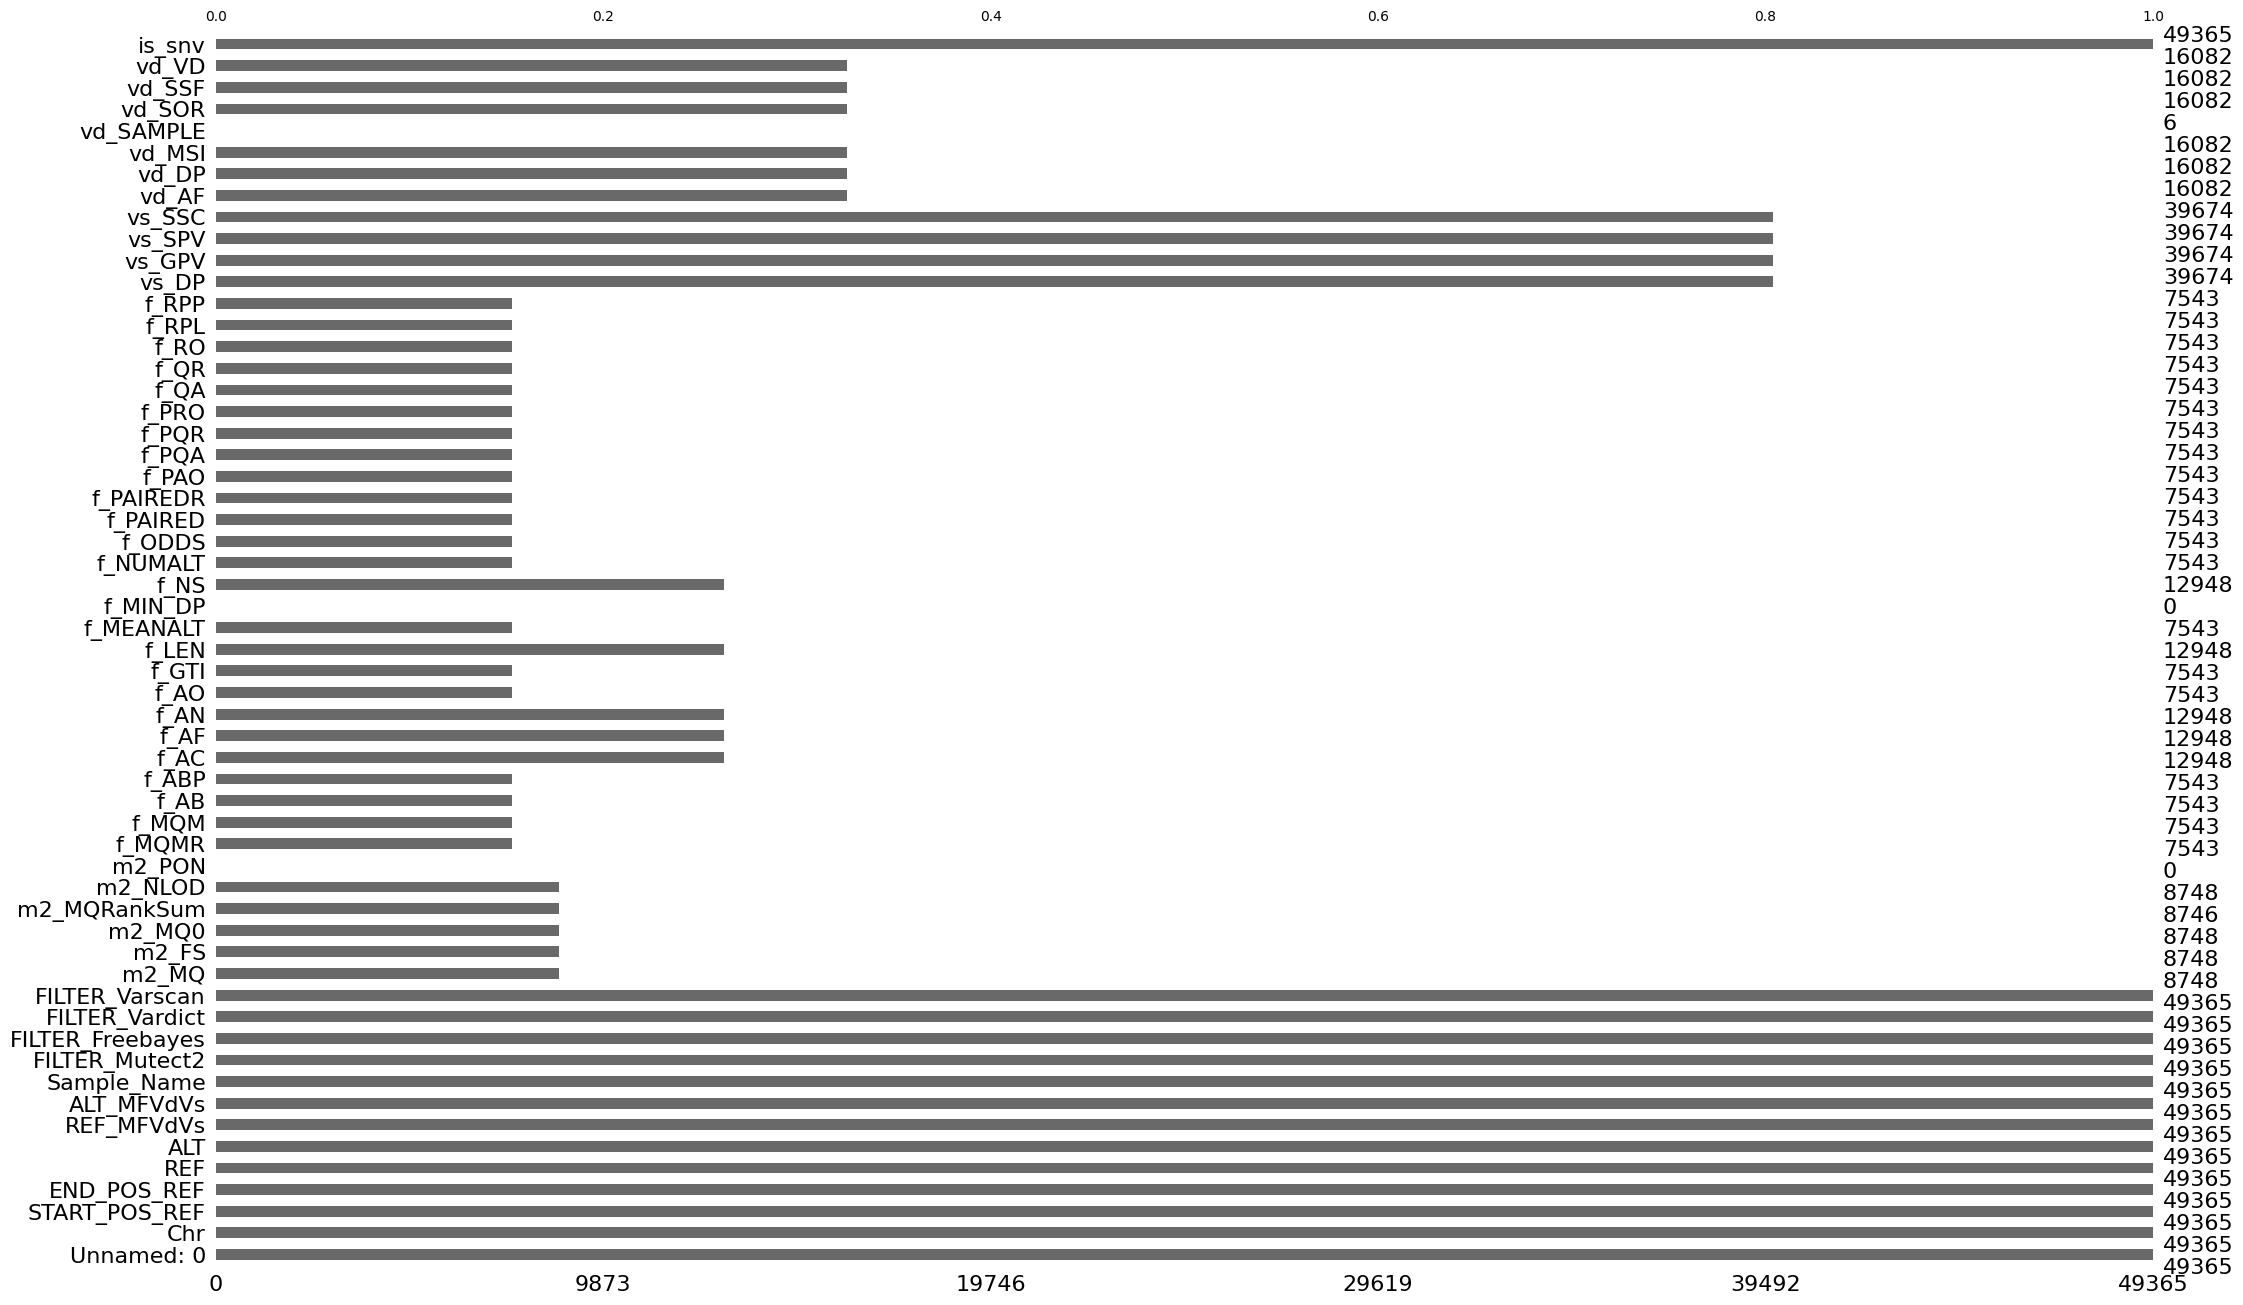

In [53]:
# Check for null values
sorted_list_of_null = (orig_df.isnull().sum()/len(orig_df)).sort_values(ascending=False)
display(sorted_list_of_null)
print(f" The dataset shape and size are :: {orig_df.shape}")
msno.bar(orig_df)

### 1. Missing Completely at Random (MCAR)

The missing values on a given variable (Y) are not associated with other variables in a given data set or with the variable (Y) itself. In other words, there is no particular reason for the missing values.

### 2. Missing at Random (MAR)

MAR occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information.

### 3. Missing Not at Random (MNAR)

Missingness depends on unobserved data or the value of the missing data itself.



<Axes: >

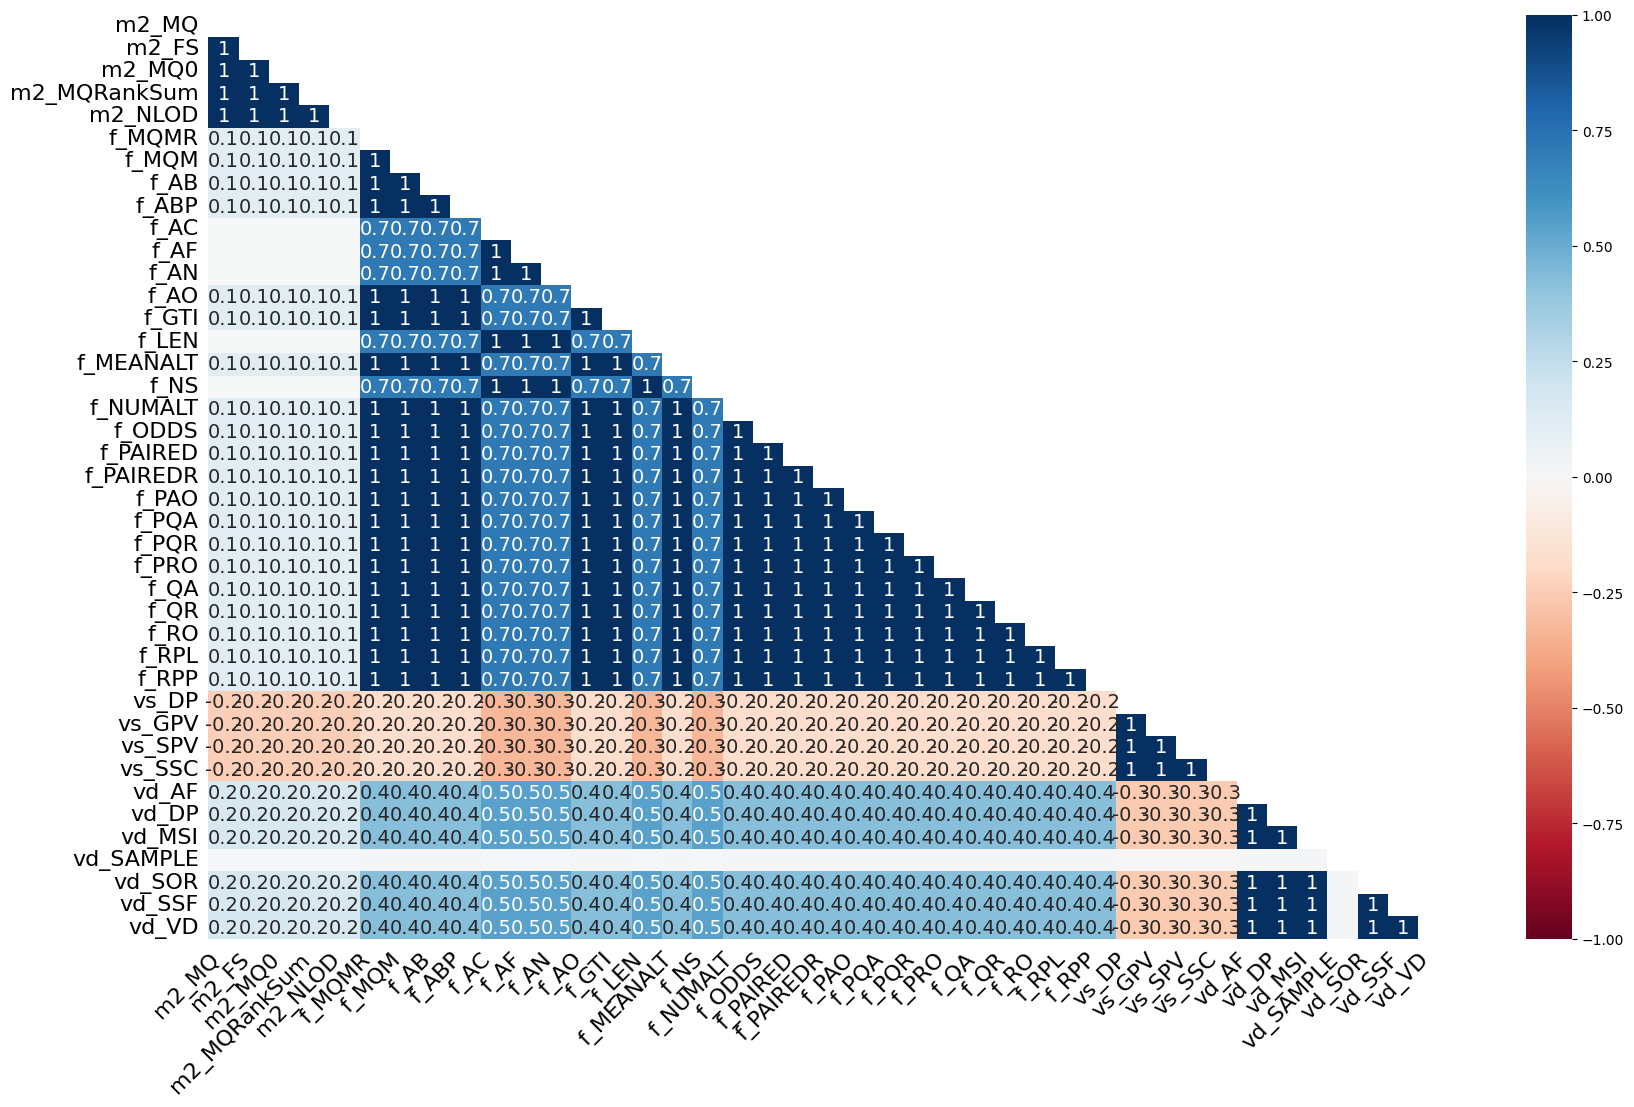

In [38]:
# The heatmap shows that for the algo if it is missing, there is a very high chance 
# That the other parameters use to predict will be missing as well
msno.heatmap(orig_df)

<Axes: >

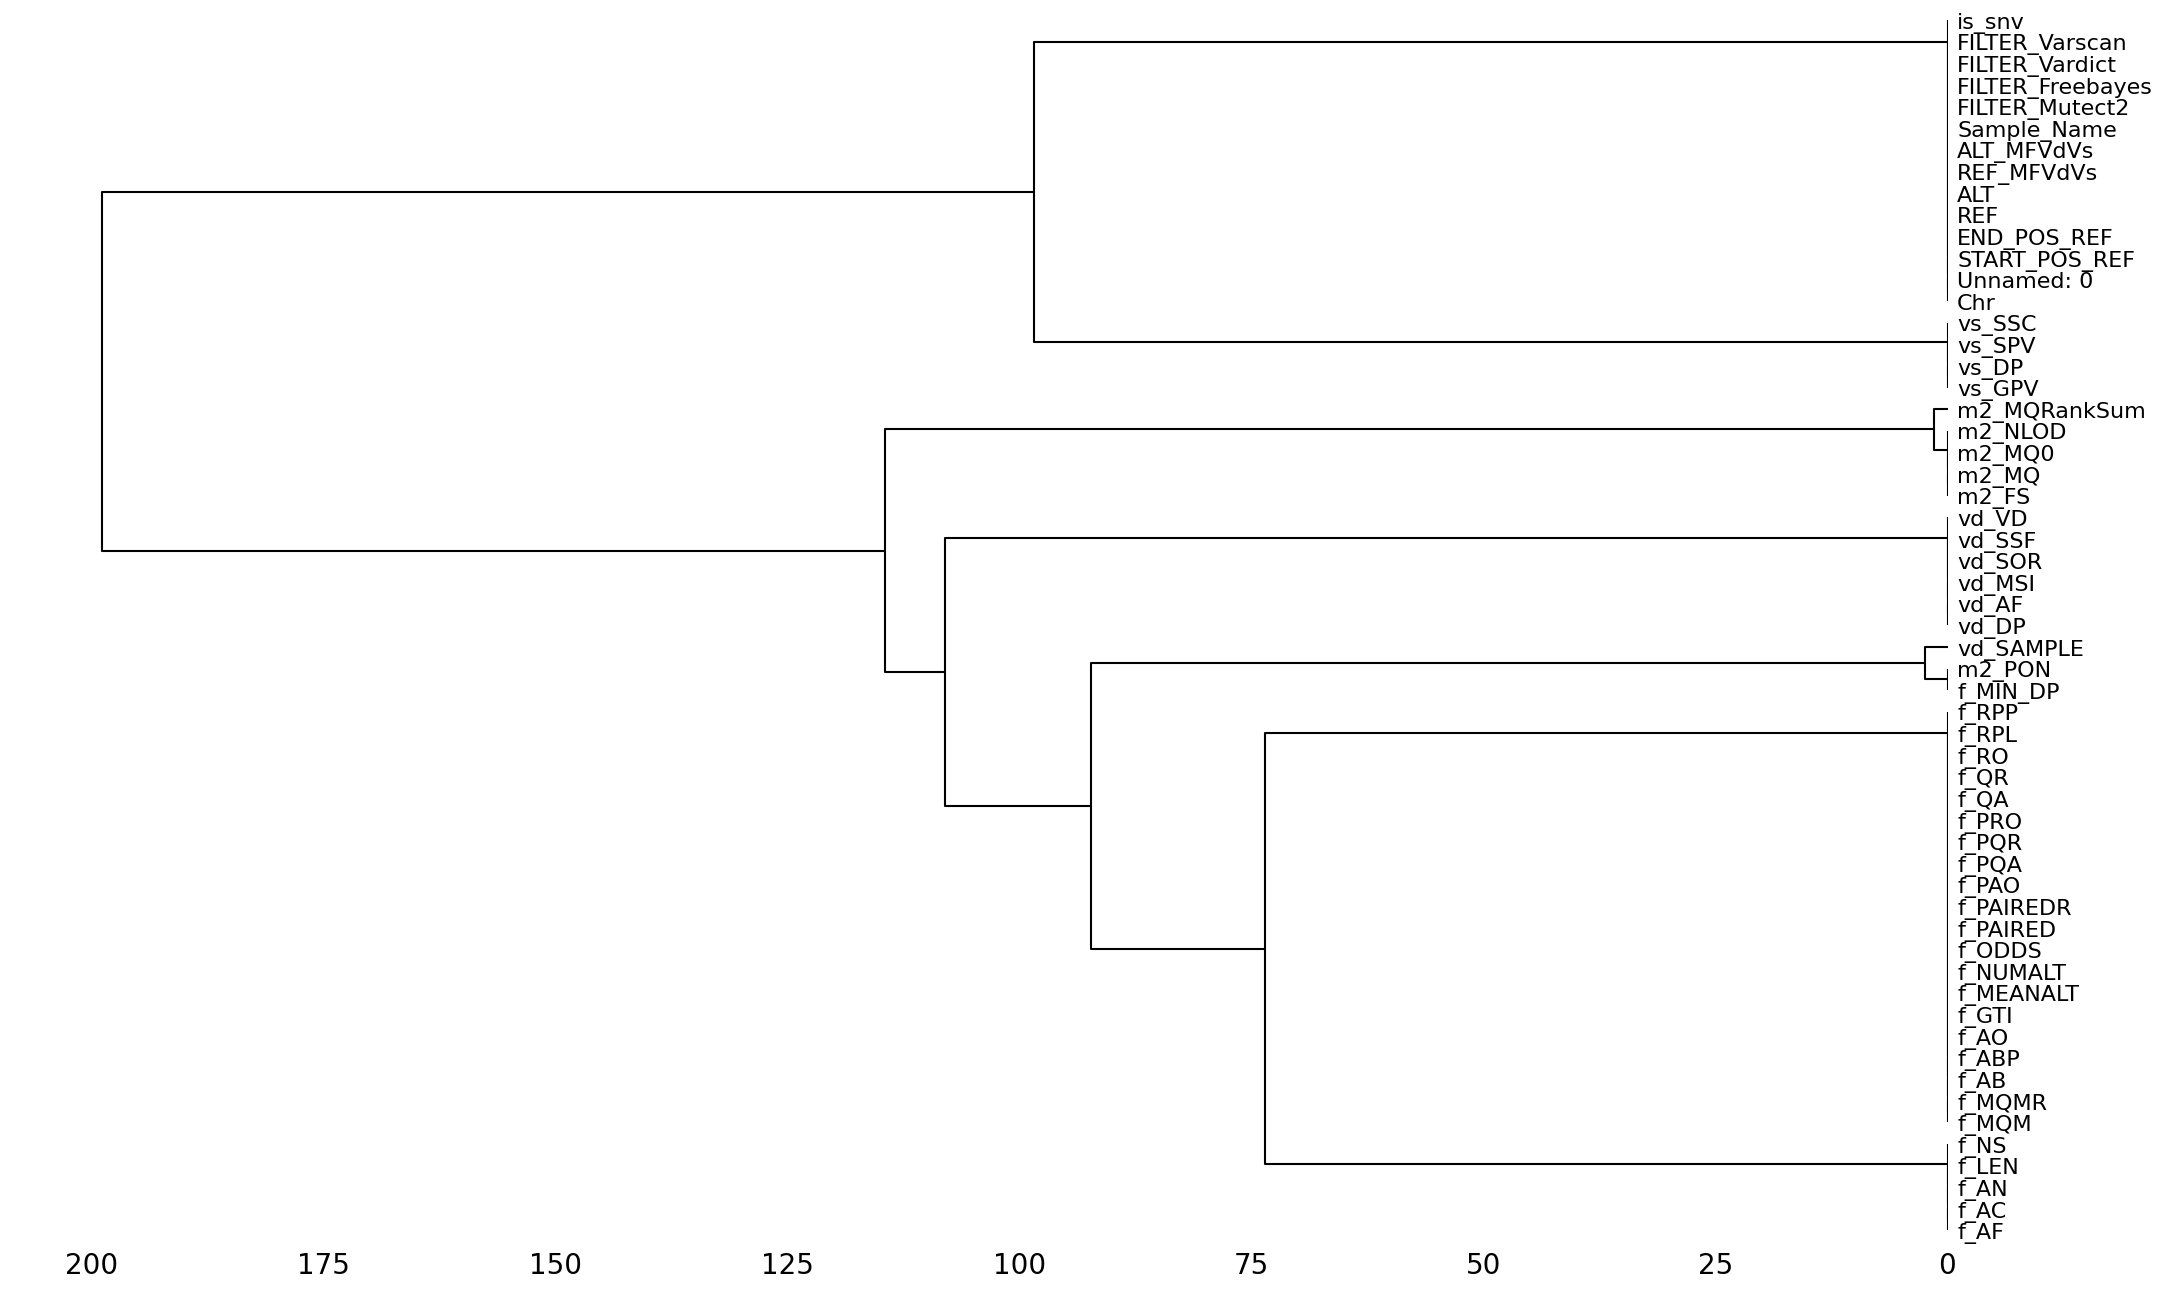

In [37]:
msno.dendrogram(orig_df)

# Reduction in Class Imbalanced Sampling Methods 

In [58]:
# class count
class_count_0, class_count_1 = orig_df['is_snv'].value_counts()

# Separate class
class_0 = orig_df[orig_df['is_snv'] == 0]
class_1 = orig_df[orig_df['is_snv'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

# Get the number of majority class to drop
maj_class = max(class_0.shape[0],class_1.shape[0])
min_class = min(class_0.shape[0],class_1.shape[0])
maj_counts = (min_class/0.4 * 0.6)
drop_num =  maj_class - (min_class/0.4 * 0.6)
print(f"To drop : {drop_num}, maj counts: {maj_counts}")

class 0: (48046, 57)
class 1: (1308, 57)
To drop : 46084.0, maj counts: 1962.0


In [79]:
# Drop from the list of non-null
key_feature = ['m2_FS',
'f_ABP',
'f_PAIREDR',
'vd_AF',
'f_GTI',
'm2_NLOD',
'f_ODDS',
'f_QR',
'f_AO',
'f_RPP']

min_kept = class_1.copy()
sampled_maj = class_0.copy()
kept_df = sampled_maj.loc[list(sampled_maj[feature_list].dropna().index)]
len_keep = len(sampled_maj[feature_list].dropna())
sample_num = maj_counts - len_keep
print(int(sample_num))
sampled_maj = sampled_maj[sampled_maj[key_feature].isna().any(axis=1)].sample(int(sample_num))

df = pd.concat([kept_df,sampled_maj,min_kept])

# Check if total numbers match
assert (maj_counts + min_class) == df.shape[0], "Does not match in numbers"
print(f"df shape :: {df.shape}")

1398
df shape :: (3270, 57)


# Data imputation
1. Imputing with a constant
2. Imputing by statistic -- Mean, Median , Mode
3. KNN Based
4. MICE Based
 
fyi :: Difficulty in doing outlier detection as well due to presence of high amount of missing data

In [80]:
# Change into features and labels 
# Dropping entirely null columns
x_df = df.copy().drop(columns=["is_snv","m2_PON","f_MIN_DP"])
y_df = df.copy()[["is_snv"]]

In [81]:
# Split data into categorical and non categorical
list_of_categorical = list()
list_of_numerical = list()

numerical = ["int64", "float64"]
for elem in x_df.dtypes.items():
    name, col_type = elem
    if col_type in numerical:
        print(f" numeric {col_type} :: {name}")
        list_of_numerical.append(name)
    else:
        print(f" cat {col_type} :: {name}")
        list_of_categorical.append(name)


 numeric int64 :: Unnamed: 0
 cat object :: Chr
 numeric int64 :: START_POS_REF
 numeric int64 :: END_POS_REF
 cat object :: REF
 cat object :: ALT
 cat object :: REF_MFVdVs
 cat object :: ALT_MFVdVs
 cat object :: Sample_Name
 cat object :: FILTER_Mutect2
 cat object :: FILTER_Freebayes
 cat object :: FILTER_Vardict
 cat object :: FILTER_Varscan
 numeric float64 :: m2_MQ
 numeric float64 :: m2_FS
 numeric float64 :: m2_MQ0
 numeric float64 :: m2_MQRankSum
 numeric float64 :: m2_NLOD
 numeric float64 :: f_MQMR
 numeric float64 :: f_MQM
 numeric float64 :: f_AB
 numeric float64 :: f_ABP
 numeric float64 :: f_AC
 numeric float64 :: f_AF
 numeric float64 :: f_AN
 numeric float64 :: f_AO
 numeric float64 :: f_GTI
 numeric float64 :: f_LEN
 numeric float64 :: f_MEANALT
 numeric float64 :: f_NS
 numeric float64 :: f_NUMALT
 numeric float64 :: f_ODDS
 numeric float64 :: f_PAIRED
 numeric float64 :: f_PAIREDR
 numeric float64 :: f_PAO
 numeric float64 :: f_PQA
 numeric float64 :: f_PQR
 numeri

In [82]:
# x_df[list_of_categorical].info()
x_df[list_of_categorical].describe()

,Chr,REF,ALT,REF_MFVdVs,ALT_MFVdVs,Sample_Name,FILTER_Mutect2,FILTER_Freebayes,FILTER_Vardict,FILTER_Varscan,vd_SAMPLE
count,3270,3270,3270,3270,3270,3270,3270,3270,3270,3270,6
unique,57,4,4,59,92,1,2,2,2,2,1
top,1,C,T,C/C/C/C/,A/A/A/A/,icgc_cll-T,True,False,False,False,icgc_cll-T
freq,248,940,988,513,549,3270,1636,1713,1775,1704,6


In [102]:
# remove certain elements
list_of_categorical = ['REF',
 'FILTER_Mutect2',
 'FILTER_Freebayes',
 'FILTER_Vardict',
 'FILTER_Varscan',]

In [84]:
# Basic check of which rows have inf values
numerical_df = x_df[list_of_numerical].copy()
m = (numerical_df == np.inf)
inf_check = numerical_df.loc[m.any(axis=1), m.any(axis=0)]
display(inf_check) # Description="Odds ratio">
# Replace inf value with nan to prevent numerical overflow for imputation methods
# df.replace(np.inf, np.nan)

# OR=1 Exposure does not affect odds of outcome
# OR>1 Exposure associated with higher odds of outcome
# OR<1 Exposure associated with lower odds of outcome

# Should I replace inf with a high value?
numerical_df = numerical_df.replace(np.inf, 100)

,vd_SOR
414,inf
421,inf
479,inf
1209,inf
1224,inf
...,...
47825,inf
47835,inf
47850,inf
49052,inf


### Mean imputation

In [85]:
numerical_mean_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# Replacing the values
numerical_mean_imp.iloc[:,:] = imp.fit_transform(numerical_mean_imp)
display(numerical_mean_imp.isna().sum())

Unnamed: 0       0
START_POS_REF    0
END_POS_REF      0
m2_MQ            0
m2_FS            0
m2_MQ0           0
m2_MQRankSum     0
m2_NLOD          0
f_MQMR           0
f_MQM            0
f_AB             0
f_ABP            0
f_AC             0
f_AF             0
f_AN             0
f_AO             0
f_GTI            0
f_LEN            0
f_MEANALT        0
f_NS             0
f_NUMALT         0
f_ODDS           0
f_PAIRED         0
f_PAIREDR        0
f_PAO            0
f_PQA            0
f_PQR            0
f_PRO            0
f_QA             0
f_QR             0
f_RO             0
f_RPL            0
f_RPP            0
vs_DP            0
vs_GPV           0
vs_SPV           0
vs_SSC           0
vd_AF            0
vd_DP            0
vd_MSI           0
vd_SOR           0
vd_SSF           0
vd_VD            0
dtype: int64

### Median imputation

In [86]:
numerical_median_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='median')
# Replacing the values
numerical_median_imp.iloc[:,:] = imp.fit_transform(numerical_median_imp)
display(numerical_median_imp.isna().sum())

Unnamed: 0       0
START_POS_REF    0
END_POS_REF      0
m2_MQ            0
m2_FS            0
m2_MQ0           0
m2_MQRankSum     0
m2_NLOD          0
f_MQMR           0
f_MQM            0
f_AB             0
f_ABP            0
f_AC             0
f_AF             0
f_AN             0
f_AO             0
f_GTI            0
f_LEN            0
f_MEANALT        0
f_NS             0
f_NUMALT         0
f_ODDS           0
f_PAIRED         0
f_PAIREDR        0
f_PAO            0
f_PQA            0
f_PQR            0
f_PRO            0
f_QA             0
f_QR             0
f_RO             0
f_RPL            0
f_RPP            0
vs_DP            0
vs_GPV           0
vs_SPV           0
vs_SSC           0
vd_AF            0
vd_DP            0
vd_MSI           0
vd_SOR           0
vd_SSF           0
vd_VD            0
dtype: int64

### Mode imputation

In [87]:
numerical_mode_imp = numerical_df.copy()
# Impute with numerical columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Replacing the values
numerical_mode_imp.iloc[:,:] = imp.fit_transform(numerical_mode_imp)
display(numerical_mode_imp.isna().sum())

Unnamed: 0       0
START_POS_REF    0
END_POS_REF      0
m2_MQ            0
m2_FS            0
m2_MQ0           0
m2_MQRankSum     0
m2_NLOD          0
f_MQMR           0
f_MQM            0
f_AB             0
f_ABP            0
f_AC             0
f_AF             0
f_AN             0
f_AO             0
f_GTI            0
f_LEN            0
f_MEANALT        0
f_NS             0
f_NUMALT         0
f_ODDS           0
f_PAIRED         0
f_PAIREDR        0
f_PAO            0
f_PQA            0
f_PQR            0
f_PRO            0
f_QA             0
f_QR             0
f_RO             0
f_RPL            0
f_RPP            0
vs_DP            0
vs_GPV           0
vs_SPV           0
vs_SSC           0
vd_AF            0
vd_DP            0
vd_MSI           0
vd_SOR           0
vd_SSF           0
vd_VD            0
dtype: int64

### K Means imputation

In [93]:
numerical_kmeans_imp = numerical_df.copy()
imp = KNNImputer(n_neighbors= 3)
numerical_kmeans_imp.iloc[:,:] = imp.fit_transform(numerical_kmeans_imp)

KeyboardInterrupt: 

# EDA of Features

[Text(0, 0, '3.28572'), Text(0, 0, '96.7143')]

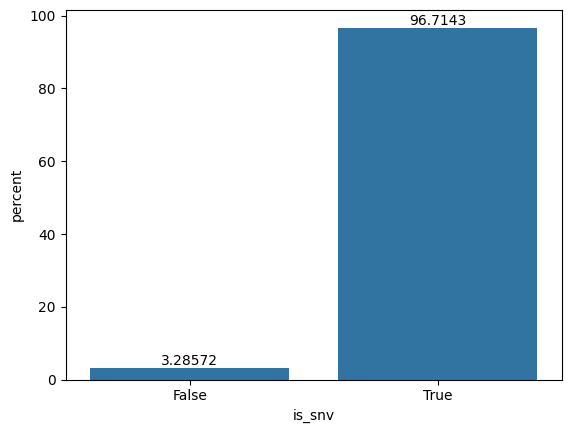

In [26]:
# Check for the proportion of SNV and non SNV
ax = sns.countplot(df, x="is_snv", stat="percent")
ax.bar_label(ax.containers[0])

In [99]:
df.columns

Index(['Unnamed: 0', 'Chr', 'START_POS_REF', 'END_POS_REF', 'REF', 'ALT',
       'REF_MFVdVs', 'ALT_MFVdVs', 'Sample_Name', 'FILTER_Mutect2',
       'FILTER_Freebayes', 'FILTER_Vardict', 'FILTER_Varscan', 'm2_MQ',
       'm2_FS', 'm2_MQ0', 'm2_MQRankSum', 'm2_NLOD', 'm2_PON', 'f_MQMR',
       'f_MQM', 'f_AB', 'f_ABP', 'f_AC', 'f_AF', 'f_AN', 'f_AO', 'f_GTI',
       'f_LEN', 'f_MEANALT', 'f_MIN_DP', 'f_NS', 'f_NUMALT', 'f_ODDS',
       'f_PAIRED', 'f_PAIREDR', 'f_PAO', 'f_PQA', 'f_PQR', 'f_PRO', 'f_QA',
       'f_QR', 'f_RO', 'f_RPL', 'f_RPP', 'vs_DP', 'vs_GPV', 'vs_SPV', 'vs_SSC',
       'vd_AF', 'vd_DP', 'vd_MSI', 'vd_SAMPLE', 'vd_SOR', 'vd_SSF', 'vd_VD',
       'is_snv'],
      dtype='object')

<Axes: xlabel='is_snv', ylabel='count'>

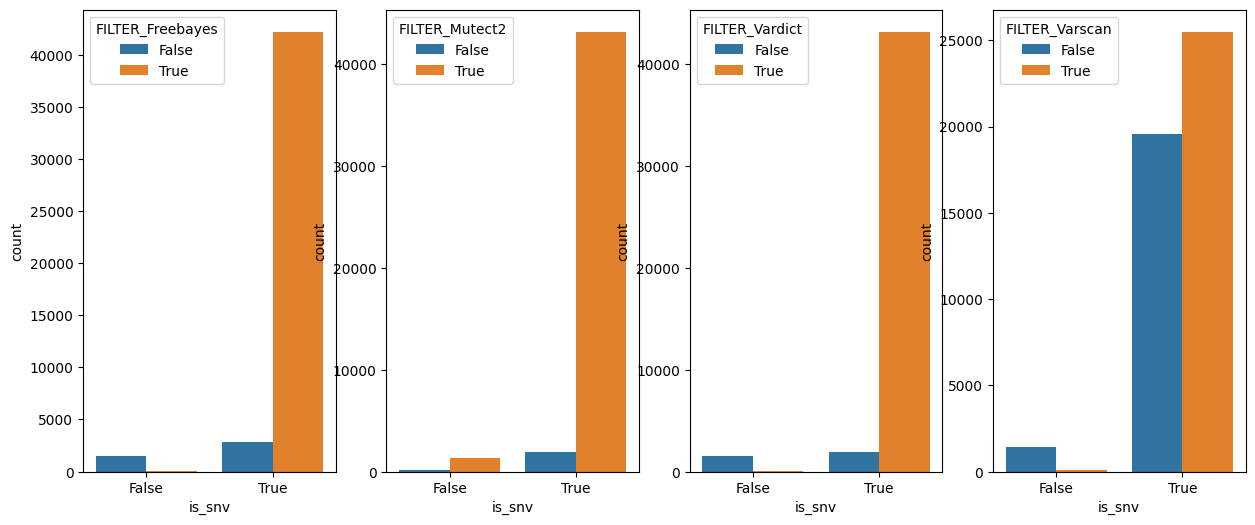

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(15,6))

sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Freebayes', ax=axs[0])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Mutect2', ax=axs[1])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Vardict', ax=axs[2])
sns.countplot(df, x="is_snv", stat="count",hue='FILTER_Varscan', ax=axs[3])

In [126]:
sns.pairplot(df[list_of_numerical])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fd33a39c550> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd329a56670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [88]:
numerical_mean_imp[list_of_numerical].var().sort_values(ascending=True)
# ['f_PAO', 'f_PQA', 'f_NS', 'f_PQR', 'f_PRO']

f_PQR            0.000000e+00
f_PQA            0.000000e+00
f_PAO            0.000000e+00
f_NS             0.000000e+00
f_PRO            0.000000e+00
f_NUMALT         1.504219e-03
f_GTI            2.530762e-03
f_AB             4.489589e-03
f_PAIREDR        7.203475e-03
f_PAIRED         9.386703e-03
vd_SSF           1.127522e-02
f_AF             1.363413e-02
vd_AF            1.755973e-02
vs_SPV           2.313151e-02
f_MEANALT        2.337665e-02
f_AN             5.269110e-02
vs_GPV           5.970551e-02
f_AC             1.634826e-01
f_LEN            7.383451e-01
m2_MQRankSum     8.210480e-01
m2_MQ            8.846774e+00
vd_MSI           9.233220e+00
m2_FS            2.758991e+01
f_MQM            3.413742e+01
f_MQMR           3.723976e+01
vs_SSC           2.402940e+02
m2_NLOD          4.892778e+02
vd_SOR           7.247434e+02
f_RPP            8.123426e+02
f_ODDS           1.370752e+03
f_RPL            1.619647e+03
vd_VD            3.076175e+03
f_ABP            3.076270e+03
vd_DP     

In [13]:
removed_cols = list()
for index, val in numerical_mean_imp[list_of_numerical].var().sort_values(ascending=True).items():
    if val == 0:
        removed_cols.append(index)
    else: break

## Categorical feature processing

In [77]:
cat_features = x_df[list_of_categorical].copy()
# Convert Filter to boolean 1/0
filter_list = [elem for elem in cat_features.columns if "FILTER" in elem]
cat_features[filter_list] = cat_features[filter_list].astype('int32')
cat_features
display(cat_features)

,REF_MFVdVs,ALT_MFVdVs,FILTER_Mutect2,FILTER_Freebayes,FILTER_Vardict,FILTER_Varscan
0,G/NA/G/G/,A/NA/A/A/,1,0,0,0
1,G/NA/NA/G/,C/NA/NA/C/,1,0,0,0
2,NA/NA/NA/A/,NA/NA/NA/C/,0,0,0,1
3,NA/NA/NA/T/,NA/NA/NA/C/,0,0,0,1
4,NA/NA/NA/T/,NA/NA/NA/C/,0,0,0,1
...,...,...,...,...,...,...
49360,T/NA/NA/NA/,C/NA/NA/NA/,1,0,0,0
49361,G/NA/NA/NA/,T/NA/NA/NA/,1,0,0,0
49362,G/NA/NA/NA/,A/NA/NA/NA/,1,0,0,0
49363,T/NA/T/T/,A/NA/A/A/,1,0,0,0


# Feature Selection

In [89]:
# Remove the cols 

# numerical_mean_imp = numerical_mean_imp.drop(columns=removed_cols)
# numerical_median_imp = numerical_median_imp.drop(columns=removed_cols)
# numerical_mode_imp = numerical_mode_imp.drop(columns=removed_cols)


In [103]:
# Concat with the cat features
mean_input = pd.concat([numerical_mean_imp,df[list_of_categorical]], axis=1)
median_input = pd.concat([numerical_median_imp,df[list_of_categorical]], axis=1)
mode_input = pd.concat([numerical_mode_imp,df[list_of_categorical]], axis=1)

In [104]:
# remove positions
mean_input = mean_input[feature_list]
median_input = median_input[feature_list]
mode_input = mode_input[feature_list]

In [105]:
cond_1 = (mode_input.shape[0] == median_input.shape[0])
cond_2 = (median_input.shape[0] == mean_input.shape[0]) 
cond_3 = (df[['Chr','START_POS_REF', 'END_POS_REF']].shape[0] == mean_input.shape[0]) 
cond_4 = (y_df.shape[0] == mean_input.shape[0]) 
assert  cond_1 & cond_2 & cond_3 & cond_4, "Wrong size"

feature_set = {
    "mean_input" : mean_input,
    "median_input": median_input,
    "mode_input": mode_input,
    "POS_IDX": df[['Chr','START_POS_REF', 'END_POS_REF']],
    "y_label" : y_df
}

In [107]:
# Save Pickle file
filepath = "/Users/melloo21/Desktop/NUS Items/CS4220/cs4220_projects/data"
feature_filename = "feature_set_real1_down_sample"
with open(f'{filepath}/{feature_filename}.pickle', 'wb') as handle:
    pickle.dump(feature_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Reduction in Class Imbalanced Sampling Methods 